## 스프린트 미션 09

- 데이터셋 :  FashionMNIST
- FashionMNIST의 각 패션 아이템을 조건부로 이미지 생성 작업 수행
- 각 클래스에 해당하는 이미지를 생성하는 cGAN(Conditional GAN)모델을 직접 설계하고 학습

데이터 구성:
- 훈련 데이터: 60,000장의 이미지
- 테스트 데이터: 10,000장의 이미지
- 28×28 크기의 흑백 이미지 (10개 클래스)

클래스 목록:
- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot

- 데이터 로드, 전처리, cGAN 모델 설계, 학습, 생성 이미지 예측 및 평가 과정을
순차적으로 진행
- 조건부 레이블을 활용해 각 패션 아이템 클래스별로 이미지를 생성하는 모델을 구현
- 생성된 이미지의 품질을 정성적(시각적 평가) 및 정량적(FID, IS 등, optional)으로 평가
- 테스트 데이터셋에 대한 모델의 조건부 생성 성능을 확인할 수 있는 결과와 함께 Notebook 파일을 제출
- 모델 성능 개선해 보기 :
 - 데이터 증강(Data Augmentation): 이미지 회전, 크롭, 밝기/대비 조절 등으로 모델의 일반화 성능을 높여보세요.
 - 하이퍼파라미터 튜닝: 학습률, 배치 크기, 에폭 수 등을 조정하여 최적의 성능을 도출
 - 모델 구조 개선: 조건부 생성 네트워크에 추가적인 레이어 등을 도입하여 성능개선을 시도

In [ ]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 78.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 53.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 176.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 40.9 MB/s eta 0:00:00


## FashionMNIST 데이터 불러오기 / 전처리

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=None
)

test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=None
)

100%|██████████| 26.4M/26.4M [00:00<00:00, 48.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 813kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 13.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.9MB/s]


In [ ]:
import matplotlib.pyplot as plt

img , label = train_dataset[0]

In [ ]:
print(f"원본 이미지 : {img.mode}")
print(f"원본 이미지 크기 : {img.size}")
print(f"원본 이미지 type : {type(img)}")
print(f"train_count = {len(train_dataset)}")
print(f"test_count = {len(test_dataset)}")

원본 이미지 : L
원본 이미지 크기 : (28, 28)
원본 이미지 type : <class 'PIL.Image.Image'>
train_count = 60000
test_count = 10000


##  증강
이미지 생성 모델은 입력 데이터 분포를 근사하는 방식으로 학습되므로,
너무 강한 데이터 증강은 분포 자체를 왜곡시켜 생성 품질에 악영향을 줄 수 있으므로 이번 실험에서는 모델이 원래 데이터 분포를 보다 정확히 학습하도록,
회전(±5도) 및 이동(±5%) 수준의 약한 증강만 적용하였습니다.

In [ ]:
transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),  # 약한 회전/이동
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Tanh를 Generator 출력에 쓰기 때문에 [-1,1] 범위로 정규화
])

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=test_transform
)

## 클래스별 데이터 개수 확인

In [ ]:
from collections import Counter

labels = [label for _, label in train_dataset]

label_counts = Counter(labels)

# 결과 출력
print("MNIST 클래스별 데이터 개수:")
for label in sorted(label_counts.keys()):
    print(f" - {label}: {label_counts[label]}개")

MNIST 클래스별 데이터 개수:
 - 0: 6000개
 - 1: 6000개
 - 2: 6000개
 - 3: 6000개
 - 4: 6000개
 - 5: 6000개
 - 6: 6000개
 - 7: 6000개
 - 8: 6000개
 - 9: 6000개


## 시드 고정

In [ ]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 1. 전체 시드 고정
set_seed(42)

# 2. DataLoader용 generator 생성
g = torch.Generator()
g.manual_seed(42)

In [ ]:
# train_dataset을 tran / val로 나누기

from torch.utils.data import random_split

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator)

In [ ]:
print(f"train_count : {len(train_dataset)}")
print(f"val_count : {len(val_dataset)}")

train_count : 54000
val_count : 6000


In [ ]:
# Dataset -> DataLoader

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle=True, worker_init_fn=seed_worker, generator=g)
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle=True, worker_init_fn=seed_worker, generator=g)
test_dataloader =  DataLoader(val_dataset, batch_size = 64, shuffle=True, worker_init_fn=seed_worker, generator=g)

In [ ]:
batch_size = 64

## cGan 모델 구조

- Generator (G)  - 입력 : z + y(노이즈 + 조건)     - 출력 : 조건을 반영한 가짜 이미지
- Discriminator(D) - 입력 : img + y (이미지 + 조건)   - 출력 : 진짜/가짜 여부(조건도 일치 했는지 포함)


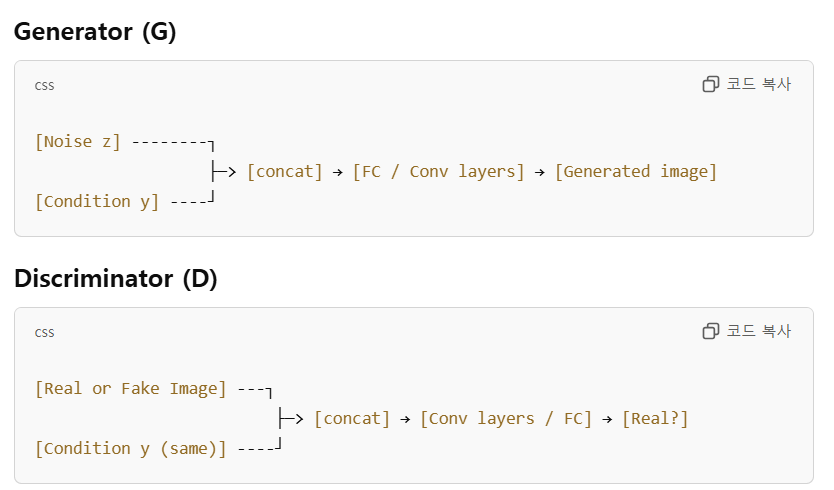

조건 정보 y 사용 방식
- One-hot 벡터 : 클래스를 one-hot 인코딩해서 noise에 concat (가장 일반적)
- 임베딩 후 concat : 	nn.Embedding으로 dense 벡터 변환 후 noise에 concat
- 이미지로 reshape : 	D에서 조건을 (1, 28, 28)로 reshape → 이미지 채널로 concat (ex: channel 2개로 입력)

Loss
- GAN은 보통 Binary Cross Entropy loss를 사용
- Discriminator loss (D): D_loss = -[log(D(x, y)) + log(1 - D(G(z, y), y))]
- Generator loss (G) : G_loss = -log(D(G(z, y), y))

## 평가지표

- 정성적 평가(시각적 평가)
- 정량적 평가
- D_loss : 진짜 이미지를 1에 가깝게, 가짜 이미지를 0에 가깝게 판단하도록 학습되는 손실값 / D_loss = -[log(D(real)) + log(1 - D(fake))]
 - 낮을수록 Discriminator가 real/fake를 잘 구분
 - 1.0~1.5 이상이면 real/fake를 잘 못 구분 -> 멍청해졌거나 G가 너무 잘 속이고 있음
 - 0.1 이하 : D가 너무 강해서 G가 학습 못함 -> mode collapse 위험

- G_loss : Generator가 생성한 이미지를 Discriminator가 진짜라고 속이도록 학습되는 손실값 / G_loss = -log(D(fake))
 - 낮을 수록 G가 D를 잘 속이고 있음
 - G Loss가 처음부터 낮음 : G가 너무 쉽게 D를 속임 -> D가 무기력
 - G Loss가 계속 높음(1.5 이상) : G가 학습이 안되거나 너무 불리한 구조

 - Real Score : Discriminator가 진짜(real) 이미지를 얼마나 "진짜"로 판단했는지의 평균값 / 보통 평균적으로 D(real_imgs, labels)의 값
 - Real Score < 0.5 : D가 진짜 이미지를 진짜라고 못 믿음
 - REal Score > 0.95 : D가 real에 대해 확신이 너무 강함 -> G 학습 어려움

- Fake Score : Discriminator가 가짜(fake) 이미지를 진짜라고 잘못 믿는 정도 /  D(G(z, y))의 평균값
 - 낮을 수록 D가 잘 구분
 - 하지만 G가 발전하면 점점 높아지는게 정상
 - 0.5부근 고정 : D가 아무 판단도 못함
 - 계속 낮음(0.1 이하) : G가 학습 안됨 or D가 너무강함
 - 점점 올라감 : G가 점점 속이고 있음 = 좋은 신호


- FID : 생성 이미지와 실제 이미지의 Inception feature 공간에서의 통계 거리
 - 평균과 공분산의 차이를 수치화
 - 낮을수록 좋음, 완벽하게 같으면 FID = 0
 - RGB 3채널로 맞춰야 함 / 흑백 1채널은 안 맞음 → .repeat(1, 3, 1, 1) 필요

- z = torch.randn(batch_size, noise_dim)
 - 평균 0, 표준편차 1의 정규분포에서 랜덤하게 샘플링
 - noise_dim = 100

- label만 넣으면 안 되는 이유
 - G는 항상 같은 label에 항상 같은 이미지를 만들게 됨
 - mode collapse (다양한 패턴이 사라지고 한 이미지만 생성) 위험도 높아짐

- noise : 스타일 , 다양성, 디테일 담당
- label(one-hot) : 클래스 정보 지정

In [ ]:
!pip install torchmetrics[image]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 156.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 146.4 MB/s eta 0:00:00


In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance

##cGAN

## cGAN 하나하나 차근차근 만들어보기

- G
 - Multilayer Perceptron (MLP): Linear Layer를 여러 층 쌓음
 - Tannh() 를 통해 출력 이미지를 [-1, 1] 범위로 만들어줌

  - 1층	Linear(110 → 128)	128	ReLU + BatchNorm1d
  - 2층	Linear(128 → 256)	256	ReLU + BatchNorm1d
  - 3층	Linear(256 → 512)	512	ReLU + BatchNorm1d
  - 4층	Linear(512 → 784)	28×28	Tanh (픽셀 정규화 [-1, 1])

- D

 - 1층	Linear(794 → 512)	512	LeakyReLU(0.2)
 - 2층	Linear(512 → 256)	256	LeakyReLU(0.2)
 - 3층	Linear(256 → 128)	128	LeakyReLU(0.2)
 - 4층	Linear(128 → 64)	64	LeakyReLU(0.2)
 - 5층	Linear(64 → 1)	1	LeakyReLU(0.2) + Sigmoid



In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Generator(nn.Module):
    # noise_dim : 랜덤 노이즈 z의 차원 / label_dim: 조건(label)의 one-hot 벡터 차원 / img_dim 출력 이미지의 크기(28*28 = 784)
    def __init__(self, noise_dim, label_dim, img_dim):
        super().__init__()
        input_dim = noise_dim + label_dim # Generator에 들어가는 입력의 차원은 노이즈 + 조건의 결합 형태. 예: z(100차원) + label(10차원) → 총 110차원 입력.
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 28*28),
            nn.Tanh() # 이미지 픽셀을 [-1, 1]로 만들기 / 실제 이미지 정규화 방식을 맞추기 위한 처리
        )

    def forward(self, noise, labels):
        x = torch.cat((noise, labels), dim=1) # 두 벡터를 이어 붙임 (dim=1 -> feature 차원)
        return self.net(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_dim, label_dim):
        super().__init__()
        input_dim = img_dim + label_dim # 28*28 + 10 = 794
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.LeakyReLU(0.2),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        x = torch.cat((img, labels), dim=1)
        return self.net(x)

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 100
label_dim = 10 # MNIST
img_dim = 28*28 # MNIST 이미지 크기

G = Generator(noise_dim, label_dim, img_dim).to(device)
D = Discriminator(img_dim, label_dim).to(device)

criterion = nn.BCELoss()
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)

## 학습

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 32.4MB/s]


Epoch [1/50], D Loss: 0.0435, G Loss: 14.8206, Real Score: 0.9984, Fake Score: 0.0366, FID: 308.8960
→ Val FID: 5.9650
Epoch [2/50], D Loss: 0.0408, G Loss: 6.8791, Real Score: 0.9999, Fake Score: 0.0357, FID: 246.4531
→ Val FID: 4.0837
Epoch [3/50], D Loss: 0.0728, G Loss: 5.5449, Real Score: 0.9819, Fake Score: 0.0432, FID: 221.9923
→ Val FID: 2.9015
Epoch [4/50], D Loss: 0.0761, G Loss: 6.4726, Real Score: 0.9857, Fake Score: 0.0503, FID: 205.1547
→ Val FID: 2.0722
Epoch [5/50], D Loss: 0.2144, G Loss: 6.3269, Real Score: 0.9514, Fake Score: 0.0540, FID: 202.2629
→ Val FID: 1.1693
Epoch [6/50], D Loss: 0.1192, G Loss: 4.9398, Real Score: 0.9964, Fake Score: 0.0983, FID: 202.0655
→ Val FID: 0.6973
Epoch [7/50], D Loss: 0.2241, G Loss: 5.7980, Real Score: 0.9324, Fake Score: 0.0720, FID: 191.7996
→ Val FID: 0.8895
Epoch [8/50], D Loss: 0.4082, G Loss: 5.0009, Real Score: 0.9547, Fake Score: 0.1445, FID: 186.4281
→ Val FID: 1.0071
Epoch [9/50], D Loss: 0.2063, G Loss: 4.4117, Real Scor

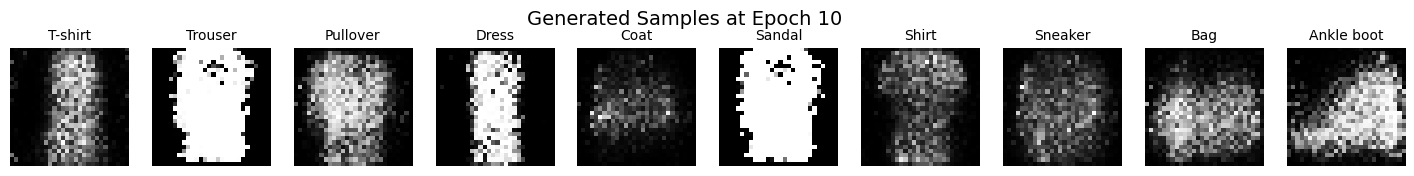

→ Val FID: 1.3315
Epoch [11/50], D Loss: 0.1799, G Loss: 3.1958, Real Score: 0.9656, Fake Score: 0.1093, FID: 189.7891
→ Val FID: 0.6184
Epoch [12/50], D Loss: 0.2472, G Loss: 4.0731, Real Score: 0.9356, Fake Score: 0.0969, FID: 192.8393
→ Val FID: 0.6978
Epoch [13/50], D Loss: 0.4857, G Loss: 3.0086, Real Score: 0.8548, Fake Score: 0.1152, FID: 188.3943
→ Val FID: 0.8633
Epoch [14/50], D Loss: 0.6644, G Loss: 2.5669, Real Score: 0.8599, Fake Score: 0.2096, FID: 182.6277
→ Val FID: 0.3403
Epoch [15/50], D Loss: 0.2816, G Loss: 3.1922, Real Score: 0.9177, Fake Score: 0.1263, FID: 179.9508
→ Val FID: 0.2814
Epoch [16/50], D Loss: 0.4376, G Loss: 2.4602, Real Score: 0.9104, Fake Score: 0.1739, FID: 175.6602
→ Val FID: 0.5221
Epoch [17/50], D Loss: 0.5519, G Loss: 2.1748, Real Score: 0.8958, Fake Score: 0.2509, FID: 172.7630
→ Val FID: 0.4573
Epoch [18/50], D Loss: 0.4320, G Loss: 2.3780, Real Score: 0.8845, Fake Score: 0.1994, FID: 176.1040
→ Val FID: 0.5832
Epoch [19/50], D Loss: 0.5458,

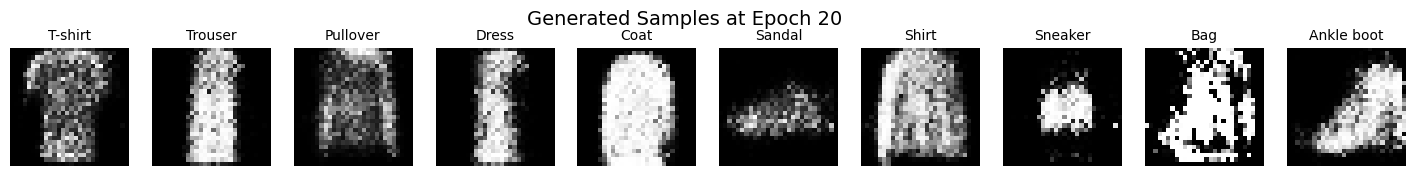

→ Val FID: 0.4294
Epoch [21/50], D Loss: 0.8033, G Loss: 2.7061, Real Score: 0.8307, Fake Score: 0.3138, FID: 162.3287
→ Val FID: 0.3597
Epoch [22/50], D Loss: 0.5186, G Loss: 2.5850, Real Score: 0.8762, Fake Score: 0.2177, FID: 158.8265
→ Val FID: 0.7991
Epoch [23/50], D Loss: 0.4773, G Loss: 2.3443, Real Score: 0.8803, Fake Score: 0.2183, FID: 163.8142
→ Val FID: 0.7321
Epoch [24/50], D Loss: 0.5700, G Loss: 2.5323, Real Score: 0.7666, Fake Score: 0.1300, FID: 154.3051
→ Val FID: 0.5340
Epoch [25/50], D Loss: 1.4850, G Loss: 1.6751, Real Score: 0.7345, Fake Score: 0.4555, FID: 152.2950
→ Val FID: 0.2650
Epoch [26/50], D Loss: 0.4602, G Loss: 1.5354, Real Score: 0.8834, Fake Score: 0.2573, FID: 153.7282
→ Val FID: 0.3216
Epoch [27/50], D Loss: 0.6696, G Loss: 1.9065, Real Score: 0.8549, Fake Score: 0.2986, FID: 154.3961
→ Val FID: 0.3190
Epoch [28/50], D Loss: 0.8280, G Loss: 1.9088, Real Score: 0.7780, Fake Score: 0.2643, FID: 154.0855
→ Val FID: 0.6661
Epoch [29/50], D Loss: 0.8565,

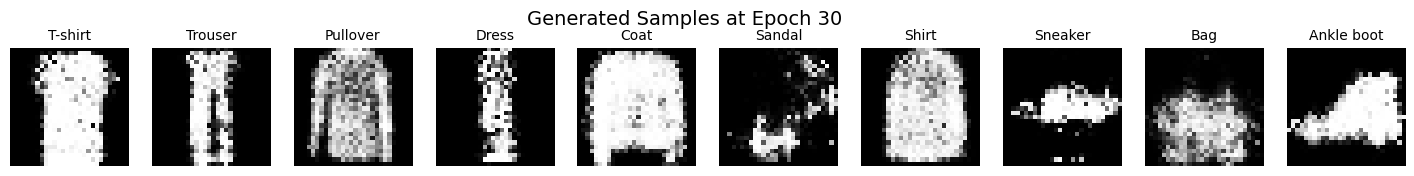

→ Val FID: 0.5300
Epoch [31/50], D Loss: 1.2143, G Loss: 1.3502, Real Score: 0.6843, Fake Score: 0.3778, FID: 155.6332
→ Val FID: 0.7327
Epoch [32/50], D Loss: 0.7890, G Loss: 2.0122, Real Score: 0.6421, Fake Score: 0.1954, FID: 151.3757
→ Val FID: 0.5205
Epoch [33/50], D Loss: 0.7604, G Loss: 2.2229, Real Score: 0.7452, Fake Score: 0.2108, FID: 145.3329
→ Val FID: 0.2648
Epoch [34/50], D Loss: 0.8253, G Loss: 1.3802, Real Score: 0.7404, Fake Score: 0.2909, FID: 143.0957
→ Val FID: 0.2507
Epoch [35/50], D Loss: 0.6078, G Loss: 2.3291, Real Score: 0.7397, Fake Score: 0.1218, FID: 138.5156
→ Val FID: 0.3118
Epoch [36/50], D Loss: 1.0591, G Loss: 2.3057, Real Score: 0.5749, Fake Score: 0.1456, FID: 142.7419
→ Val FID: 0.5612
Epoch [37/50], D Loss: 1.2354, G Loss: 1.1356, Real Score: 0.6065, Fake Score: 0.3857, FID: 143.2361
→ Val FID: 0.2825
Epoch [38/50], D Loss: 0.7412, G Loss: 1.6282, Real Score: 0.7122, Fake Score: 0.2466, FID: 145.9998
→ Val FID: 0.2158
Epoch [39/50], D Loss: 0.9181,

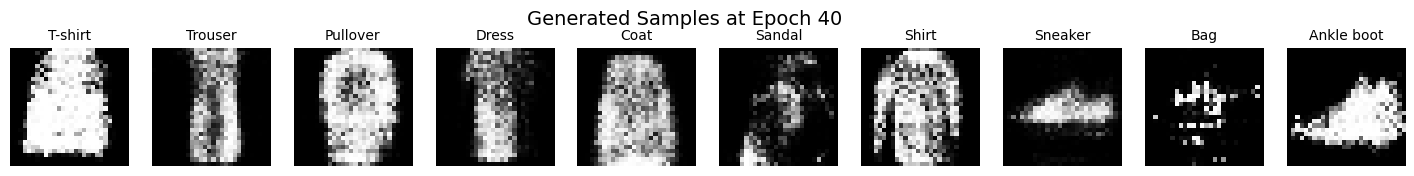

→ Val FID: 0.3588
Epoch [41/50], D Loss: 0.8912, G Loss: 1.4491, Real Score: 0.7147, Fake Score: 0.3071, FID: 142.7752
→ Val FID: 0.4792
Epoch [42/50], D Loss: 0.6109, G Loss: 1.5120, Real Score: 0.8031, Fake Score: 0.2744, FID: 138.6571
→ Val FID: 0.3229
Epoch [43/50], D Loss: 0.8846, G Loss: 1.0964, Real Score: 0.7254, Fake Score: 0.3499, FID: 136.4326
→ Val FID: 0.3014
Epoch [44/50], D Loss: 0.5076, G Loss: 1.4468, Real Score: 0.9117, Fake Score: 0.2992, FID: 142.1032
→ Val FID: 0.3068
Epoch [45/50], D Loss: 1.3067, G Loss: 0.9524, Real Score: 0.6133, Fake Score: 0.4838, FID: 134.6387
→ Val FID: 0.2081
Epoch [46/50], D Loss: 1.0825, G Loss: 1.2796, Real Score: 0.7639, Fake Score: 0.4361, FID: 141.7577
→ Val FID: 0.3348
Epoch [47/50], D Loss: 0.6909, G Loss: 1.6096, Real Score: 0.7598, Fake Score: 0.2820, FID: 132.3249
→ Val FID: 0.3050
Epoch [48/50], D Loss: 1.1495, G Loss: 1.3374, Real Score: 0.5523, Fake Score: 0.3068, FID: 138.8463
→ Val FID: 0.4985
Epoch [49/50], D Loss: 0.9875,

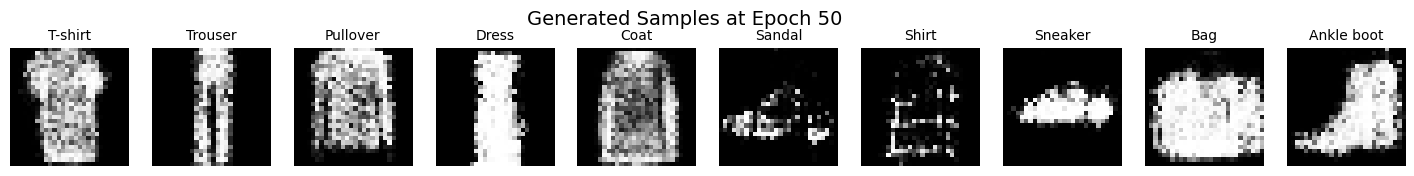

→ Val FID: 0.2584


NameError: name 'run' is not defined

In [ ]:
## import torch
import torch.nn.functional as F
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# FID 계산용 metric
fid = FrechetInceptionDistance(feature=2048).to(device)
num_epochs = 50

for epoch in range(num_epochs):
    for real_imgs, labels in train_dataloader:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.view(batch_size, -1).to(device) # Flatten

        # One-hot 인코딩 : 1 * 10 벡터로 만들어줌
        labels = torch.nn.functional.one_hot(labels, num_classes=label_dim).float().to(device)
        noise = torch.randn(batch_size, noise_dim).to(device) # 64개의 랜덤 벡터 / 100차원 / 평균 0, 표준편차 1
        fake_imgs = G(noise, labels)

        # --- Discriminator ---
        real_preds = D(real_imgs, labels) # 1:진짜라 예측 / 0 : 가짜라 예측
        # PyTorch는 자동 미분(autograd) 시스템 사용
        # 연산을 수행한 텐서는 "어디서부터 만들어졌는지 추적하고 있고",
        # 이 정보는 뒤에서 .backward()를 호출할 때 자동으로 따라 올라가서
        # 그 앞 노드(G의 weight)까지 gradient를 전달
        # 따라서 fake_imgs.detach()를 통해 역전파 시 G까지 흘러가는걸 막음
        fake_preds = D(fake_imgs.detach(), labels)

        real_score = real_preds.mean().item()
        fake_score = fake_preds.mean().item()

        d_loss_real = criterion(real_preds, torch.ones_like(real_preds))
        d_loss_fake = criterion(fake_preds, torch.zeros_like(fake_preds))
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad() # 초기화
        d_loss.backward() # 역전파
        d_optimizer.step() # 가중치 업데이트

        # --- Generator ---
        fake_preds = D(fake_imgs, labels)
        g_loss = criterion(fake_preds, torch.ones_like(fake_preds)) # 0에 가까울수록 D가 잘 판
        # -> D가 너무 좋으먼 학습이 안될수 있음 / gradient가 사라지거나 무의미한 방향으로 작아져서 학습이 안 됨
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # --- FID 업데이트 (Train 기준) ---
        with torch.no_grad():
            fake_imgs_reshape = fake_imgs.view(-1, 1, 28, 28)
            real_imgs_reshape = real_imgs.view(-1, 1, 28, 28)

            fake_imgs_rgb = fake_imgs_reshape.repeat(1, 3, 1, 1)
            real_imgs_rgb = real_imgs_reshape.repeat(1, 3, 1, 1)

            fake_imgs_resized = F.interpolate(fake_imgs_rgb, size=(299, 299), mode='bilinear', align_corners=False)
            real_imgs_resized = F.interpolate(real_imgs_rgb, size=(299, 299), mode='bilinear', align_corners=False)

            fake_imgs_uint8 = ((fake_imgs_resized + 1) * 127.5).clamp(0, 255).to(torch.uint8)
            real_imgs_uint8 = ((real_imgs_resized + 1) * 127.5).clamp(0, 255).to(torch.uint8)

            fid.update(real_imgs_uint8, real=True)
            fid.update(fake_imgs_uint8, real=False)

    # Epoch 종료 후 FID 계산
    fid_score = fid.compute().item()
    fid.reset()

    print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
          f"Real Score: {real_score:.4f}, Fake Score: {fake_score:.4f}, "
          f"FID: {fid_score:.4f}")

    # --- 이미지 시각화 ---
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            class_labels = torch.arange(label_dim).to(device)  # 0~9
            one_hot_labels = torch.nn.functional.one_hot(class_labels, num_classes=label_dim).float().to(device)
            noise = torch.randn(label_dim, noise_dim).to(device)

            generated_imgs = G(noise, one_hot_labels).view(-1, 1, 28, 28)
            generated_imgs = (generated_imgs + 1) / 2  # [-1,1] → [0,1]

            # ---- 시각화 (클래스 이름 포함) ----
            class_names = [
                "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
            ]

            fig, axes = plt.subplots(1, label_dim, figsize=(18, 2))
            for i in range(label_dim):
                axes[i].imshow(generated_imgs[i][0].cpu(), cmap="gray")
                axes[i].set_title(class_names[i], fontsize=10)
                axes[i].axis("off")

            plt.suptitle(f"Generated Samples at Epoch {epoch + 1}", fontsize=14)
            plt.show()

    # --- val 기반 FID 계산 (과적합 확인용) ---
    fid_val = FrechetInceptionDistance(feature=64).to(device)

    with torch.no_grad():
        for val_imgs, val_labels in val_dataloader:
            val_imgs = val_imgs.to(device)
            val_labels_oh = torch.nn.functional.one_hot(val_labels, num_classes=label_dim).float().to(device)

            noise = torch.randn(val_labels_oh.size(0), noise_dim).to(device)
            val_fake = G(noise, val_labels_oh).view(-1, 1, 28, 28)

            val_fake_rgb = val_fake.repeat(1, 3, 1, 1)
            val_real_rgb = val_imgs.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)

            val_fake_resized = F.interpolate(val_fake_rgb, size=(299, 299), mode='bilinear', align_corners=False)
            val_real_resized = F.interpolate(val_real_rgb, size=(299, 299), mode='bilinear', align_corners=False)

            val_fake_uint8 = ((val_fake_resized + 1) * 127.5).clamp(0, 255).to(torch.uint8)
            val_real_uint8 = ((val_real_resized + 1) * 127.5).clamp(0, 255).to(torch.uint8)

            fid_val.update(val_real_uint8, real=True)
            fid_val.update(val_fake_uint8, real=False)

    fid_val_score = fid_val.compute().item()
    fid_val.reset()

    print(f"→ Val FID: {fid_val_score:.4f}")

    # epoch 루프 안에서 로그 기록

    wandb.log({
    "Epoch": epoch + 1,
    "Discriminator Loss": d_loss.item(),
    "Generator Loss": g_loss.item(),
    "Real Score": real_score,
    "Fake Score": fake_score,
    "Train FID": fid_score,
    "Val FID": fid_val_score
})

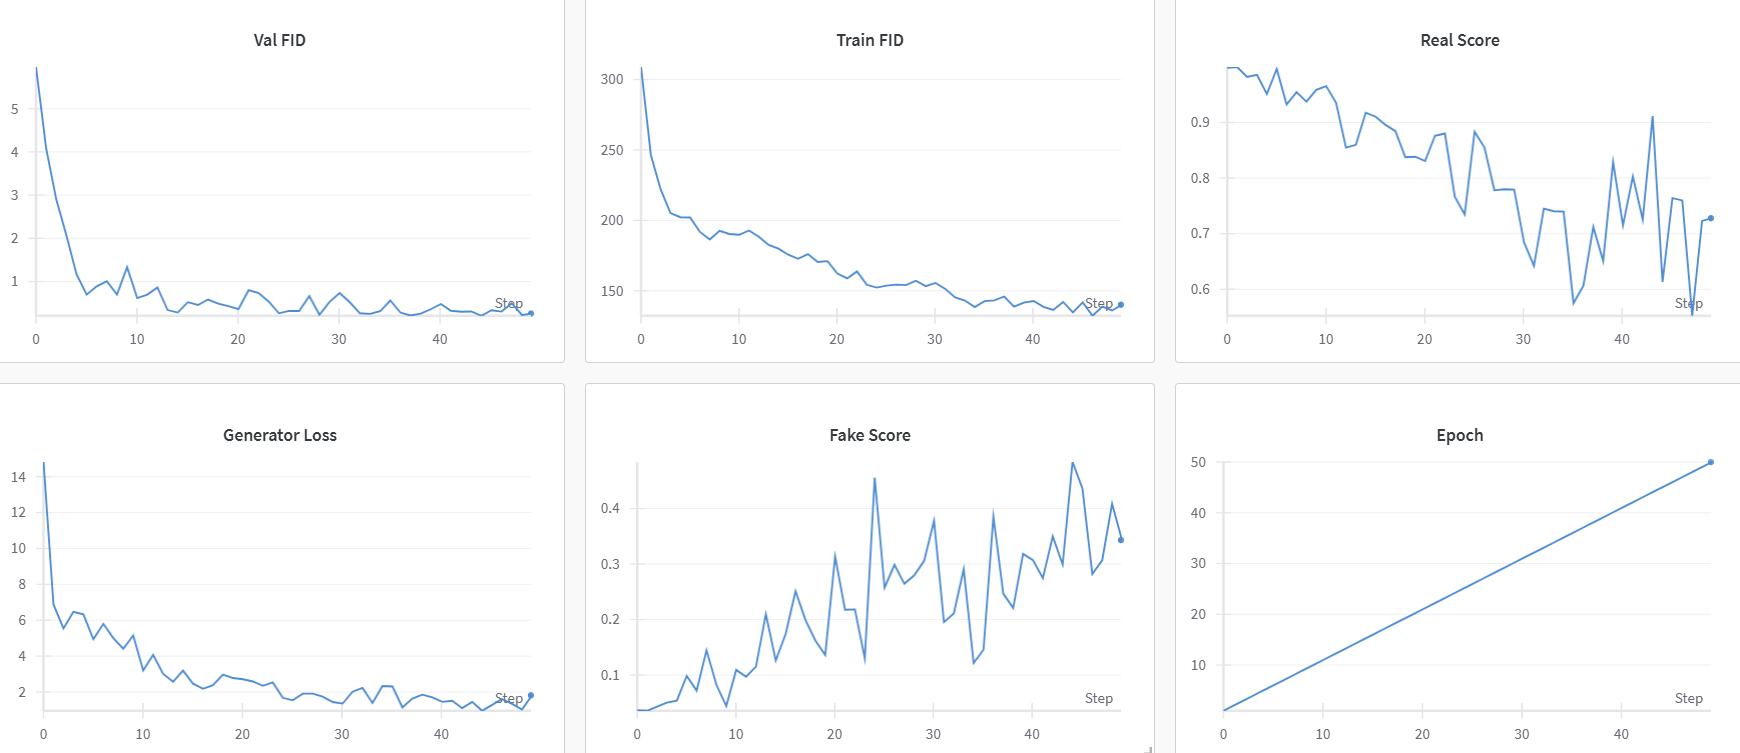

- 학습을 진행 할수록 Fake Score가 상승하는 형태를 보임
- 학습을 진행 할수록 G Loss 값과 FID 수치가 떨어지고 Real Score 가 떨어짐
- G 모델이 에폭이 지날수록 성능이 좋아지면서 D 모델을 속이는 Fake Score 가 상승하는 것으로 보이며 / 다시 D모델의 분류 능력이 좋아졌을때 Fake Score가 줄어들고 Real Score가 올라가는 그래프를 보임
- 위의 현상을 반복하며 모델의 분류성능과 이미지 생성 모델의 능력이 상승함을 알수있으며 이는 FID의 수치가 계속 떨어지고 있으며 생성된 이미지의 시각화 결과가 좋아짐을 토대로 확인할 수 있음

- 다만 모델을 MLP 구조로 설계하여 이미지 픽셀을 펼쳐서 픽셀단위로 학습을 하다보니 생성된 이미지의 경계가 부드럽지 않고 (공간 정보 활용하지못함) 모델의 학습 속도가 느린 현상을 확인할 수 있었음
- 더 많은 에폭을 돌린다면 FID 수치가 더 줄어들고 더 좋은 상태의 이미지가 생성될 것으로 예상
  
- val FID 값은 모델의 과적합을 확인하기위해 넣은 지표인데 fid_val 변수의 feature를 2048로 줬어야 했으나 64로 잘못주어서 FID 값과 Val FID 값과의 큰차이가 난것으로 보이며, 2048을 사용한 FID 수치가 정확한 수치로 보임

## 모델 구조 변화

- MLP -> CNN 기반으로 구조 변경
- 공간정보까지 활용 가능하므로 더 부드러운 경계를 보이는 생성형 이미지가 나타날것으로 기대

In [ ]:
class CNN_Generator(nn.Module):
    # noise_dim : 랜덤 노이즈 z의 차원 / label_dim: 조건(label)의 one-hot 벡터 차원 / img_dim 출력 이미지의 크기(28*28 = 784)
    def __init__(self, noise_dim, label_dim, img_shape=(1, 28, 28)):
        super().__init__()
        self.img_shape = img_shape
        input_dim = noise_dim + label_dim

        # noise + label -> CNN이 받아들일 수 있는 3차원 텐서로 reshape
        # [Batch, Channels, Height, Width] → [B, 128, 7, 7]
        #
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU()
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),  # 7x7 → 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 14x14 → 28x28
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),              # 유지하면서 세밀하게 보정
            nn.Tanh()
        )

    def forward(self, noise, labels):
        x = torch.cat((noise, labels), dim=1)  # [batch, noise+label]
        x = self.fc(x)
        x = x.view(x.size(0), 128, 7, 7)        # reshape to image-like tensor
        img = self.deconv(x)
        return img

In [ ]:
class CNN_Discriminator(nn.Module):
    def __init__(self, label_dim):
        super().__init__()
        self.label_dim = label_dim

        # label을 이미지처럼 reshape해서 concat할 수 있도록 변환
        # 입력된 one-hot label(예: 10차원)을 784차원으로 매핑 -> 28x28 이미지처럼 reshape할 수 있게 만들어줌
        self.label_embedding = nn.Linear(label_dim, 28 * 28)

        self.conv = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),   # 28x28 → 14x14
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 14x14 → 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # 7x7 → 7x7 유지
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        self.fc = nn.Sequential(

            # 256개의 7x7 값을 평균 내서 → 256개의 숫자(1x1)로 축소
            # nn.AdaptiveAvgPool2d(1),  # [B, 256, 7, 7] → [B, 256, 1, 1]
            # nn.Flatten(),             # → [B, 256]
            # nn.Linear(256, 1),        # → [B, 1]
            # nn.Sigmoid()
            nn.Conv2d(256, 1, kernel_size=1),  # [B, 256, 7, 7] → [B, 1, 7, 7]
            nn.AdaptiveAvgPool2d(1),          # [B, 1, 7, 7] → [B, 1, 1, 1]
            nn.Flatten()                      # → [B, 1]

        )

    def forward(self, img, labels):
        # labels: [B, 10] → [B, 1, 28, 28]
        label_map = self.label_embedding(labels).view(-1, 1, 28, 28)

        # 이미지와 라벨을 채널 방향으로 concat: [B, 2, 28, 28]
        x = torch.cat((img, label_map), dim=1)

        x = self.conv(x)
        out = self.fc(x)
        return out

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 100
label_dim = 10 # MNIST

G_CNN = CNN_Generator(noise_dim, label_dim).to(device)
D_CNN = CNN_Discriminator(label_dim).to(device)

criterion = nn.BCEWithLogitsLoss()
g_optimizer = optim.Adam(G_CNN.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D_CNN.parameters(), lr=0.0002, betas=(0.5, 0.999))

Epoch [1/50], D Loss: 1.3195, G Loss: 0.6423, Real Score: 0.3196, Fake Score: 0.1520, FID: 132.1613
→ Val FID: 137.6958
Epoch [2/50], D Loss: 1.3516, G Loss: 0.6239, Real Score: 0.1851, Fake Score: 0.1026, FID: 67.0392
→ Val FID: 57.4251
Epoch [3/50], D Loss: 1.3345, G Loss: 0.6383, Real Score: 0.1727, Fake Score: 0.0592, FID: 46.2403
→ Val FID: 53.0531
Epoch [4/50], D Loss: 1.3350, G Loss: 0.6700, Real Score: 0.3162, Fake Score: 0.1774, FID: 42.9329
→ Val FID: 47.9915
Epoch [5/50], D Loss: 1.3303, G Loss: 0.6377, Real Score: 0.2446, Fake Score: 0.1122, FID: 37.2296
→ Val FID: 38.7432
Epoch [6/50], D Loss: 1.3091, G Loss: 0.6476, Real Score: 0.2876, Fake Score: 0.1062, FID: 33.6867
→ Val FID: 36.5345
Epoch [7/50], D Loss: 1.3345, G Loss: 0.6466, Real Score: 0.1555, Fake Score: 0.0444, FID: 31.6168
→ Val FID: 34.1951
Epoch [8/50], D Loss: 1.3353, G Loss: 0.6460, Real Score: 0.2337, Fake Score: 0.1137, FID: 29.5738
→ Val FID: 34.1346
Epoch [9/50], D Loss: 1.3462, G Loss: 0.6577, Real Sco

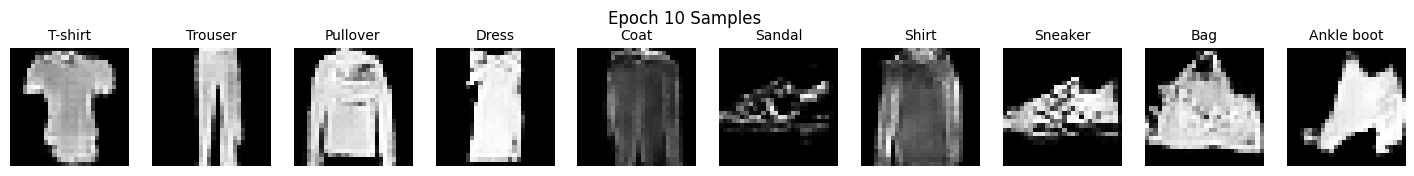

→ Val FID: 29.7490
Epoch [11/50], D Loss: 1.3347, G Loss: 0.6142, Real Score: 0.1656, Fake Score: 0.0539, FID: 25.0020
→ Val FID: 29.9395
Epoch [12/50], D Loss: 1.3457, G Loss: 0.6612, Real Score: 0.2771, Fake Score: 0.1678, FID: 23.9165
→ Val FID: 29.1017
Epoch [13/50], D Loss: 1.3293, G Loss: 0.6720, Real Score: 0.2882, Fake Score: 0.1456, FID: 23.0522
→ Val FID: 27.0551
Epoch [14/50], D Loss: 1.3603, G Loss: 0.6607, Real Score: 0.1244, Fake Score: 0.0668, FID: 22.0890
→ Val FID: 26.4334
Epoch [15/50], D Loss: 1.3493, G Loss: 0.6529, Real Score: 0.1559, Fake Score: 0.0733, FID: 21.2095
→ Val FID: 27.4848
Epoch [16/50], D Loss: 1.2959, G Loss: 0.6490, Real Score: 0.2751, Fake Score: 0.0725, FID: 20.5339
→ Val FID: 27.2718
Epoch [17/50], D Loss: 1.3447, G Loss: 0.6687, Real Score: 0.1475, Fake Score: 0.0568, FID: 20.5097
→ Val FID: 12.2257
Epoch [18/50], D Loss: 1.3490, G Loss: 0.6389, Real Score: 0.1784, Fake Score: 0.0927, FID: 6.3294
→ Val FID: -93.9721
Epoch [19/50], D Loss: 1.3124

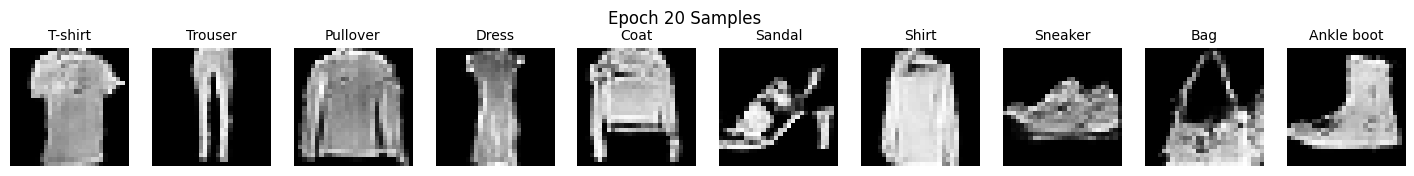

→ Val FID: -21.7209
Epoch [21/50], D Loss: 1.3139, G Loss: 0.6622, Real Score: 0.2892, Fake Score: 0.1180, FID: -45.0782
→ Val FID: -53.9757
Epoch [22/50], D Loss: 1.2973, G Loss: 0.6633, Real Score: 0.3166, Fake Score: 0.1078, FID: -73.5442
→ Val FID: -59.3711
Epoch [23/50], D Loss: 1.3112, G Loss: 0.6567, Real Score: 0.2800, Fake Score: 0.1055, FID: -17.8986
→ Val FID: -51.8922
Epoch [24/50], D Loss: 1.3405, G Loss: 0.6718, Real Score: 0.3025, Fake Score: 0.1785, FID: -34.1459
→ Val FID: -97.3199
Epoch [25/50], D Loss: 1.3407, G Loss: 0.6793, Real Score: 0.3127, Fake Score: 0.1848, FID: -10.9383
→ Val FID: 20.7233
Epoch [26/50], D Loss: 1.3115, G Loss: 0.6777, Real Score: 0.3641, Fake Score: 0.1709, FID: -15.7431
→ Val FID: 19.9746
Epoch [27/50], D Loss: 1.3535, G Loss: 0.6575, Real Score: 0.2060, Fake Score: 0.1250, FID: 16.0970
→ Val FID: 1.0326
Epoch [28/50], D Loss: 1.3080, G Loss: 0.6689, Real Score: 0.2929, Fake Score: 0.1096, FID: -0.9739
→ Val FID: 13.6247
Epoch [29/50], D Lo

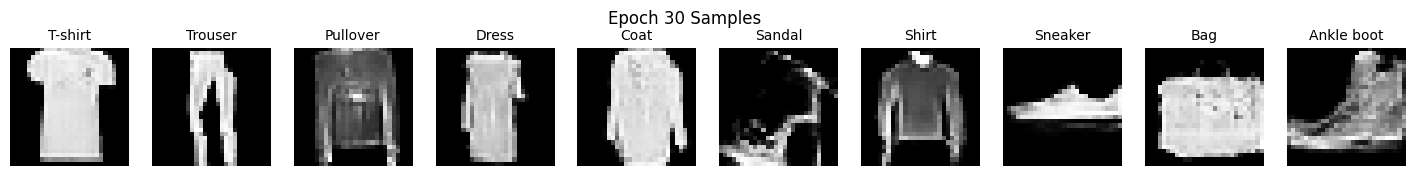

→ Val FID: 14.6525
Epoch [31/50], D Loss: 1.2992, G Loss: 0.6594, Real Score: 0.2362, Fake Score: 0.0468, FID: -34.8872
→ Val FID: -81.8152
Epoch [32/50], D Loss: 1.3025, G Loss: 0.6505, Real Score: 0.2647, Fake Score: 0.0768, FID: -35.2658
→ Val FID: -123.2430
Epoch [33/50], D Loss: 1.3293, G Loss: 0.6656, Real Score: 0.1587, Fake Score: 0.0376, FID: -75.8446
→ Val FID: -8.9881
Epoch [34/50], D Loss: 1.2862, G Loss: 0.6812, Real Score: 0.3779, Fake Score: 0.1355, FID: -59.6250
→ Val FID: -55.7887
Epoch [35/50], D Loss: 1.3426, G Loss: 0.6703, Real Score: 0.1229, Fake Score: 0.0311, FID: 0.3606
→ Val FID: -1.1940
Epoch [36/50], D Loss: 1.2872, G Loss: 0.6769, Real Score: 0.3608, Fake Score: 0.1242, FID: -110.7617
→ Val FID: -110.2096
Epoch [37/50], D Loss: 1.2792, G Loss: 0.6808, Real Score: 0.3872, Fake Score: 0.1286, FID: -25.8478
→ Val FID: -31.1147
Epoch [38/50], D Loss: 1.3076, G Loss: 0.6529, Real Score: 0.1953, Fake Score: 0.0276, FID: -107.3568
→ Val FID: -54.8225
Epoch [39/50]

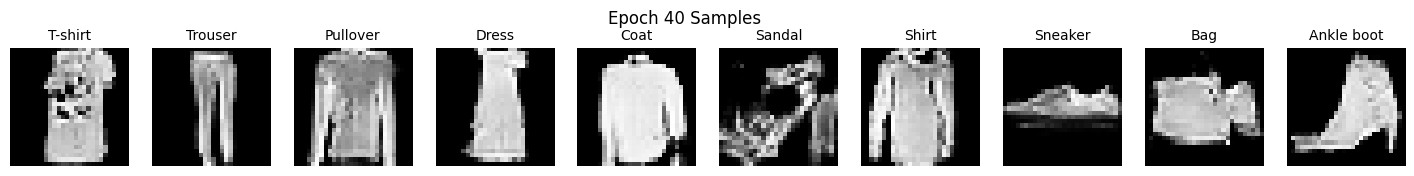

→ Val FID: -23.7383
Epoch [41/50], D Loss: 1.2871, G Loss: 0.6809, Real Score: 0.4116, Fake Score: 0.1622, FID: -39.0887
→ Val FID: 10.9856
Epoch [42/50], D Loss: 1.2865, G Loss: 0.6797, Real Score: 0.3181, Fake Score: 0.0904, FID: -21.9526
→ Val FID: 18.2449
Epoch [43/50], D Loss: 1.2982, G Loss: 0.6724, Real Score: 0.3133, Fake Score: 0.1081, FID: 0.8749
→ Val FID: 18.3326
Epoch [44/50], D Loss: 1.3462, G Loss: 0.6662, Real Score: 0.1441, Fake Score: 0.0574, FID: -1.0415
→ Val FID: 19.5413
Epoch [45/50], D Loss: 1.3305, G Loss: 0.6834, Real Score: 0.4296, Fake Score: 0.2525, FID: 13.4583
→ Val FID: 18.7126
Epoch [46/50], D Loss: 1.3378, G Loss: 0.6804, Real Score: 0.3751, Fake Score: 0.2283, FID: 13.5021
→ Val FID: 13.5934
Epoch [47/50], D Loss: 1.3322, G Loss: 0.6716, Real Score: 0.3782, Fake Score: 0.2187, FID: 10.5189
→ Val FID: 0.2355
Epoch [48/50], D Loss: 1.2877, G Loss: 0.6769, Real Score: 0.3707, Fake Score: 0.1330, FID: -2.5061
→ Val FID: -4.6388
Epoch [49/50], D Loss: 1.229

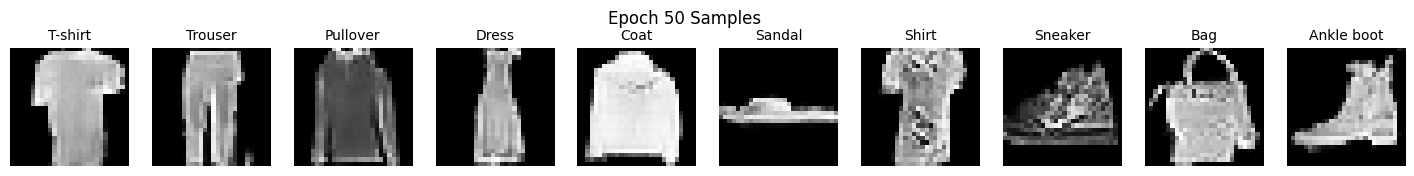

→ Val FID: -57.1821


NameError: name 'run' is not defined

In [ ]:
fid = FrechetInceptionDistance(feature=2048).to(device)
num_epochs = 50

for epoch in range(num_epochs):
    for real_imgs, labels in train_dataloader:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        labels = F.one_hot(labels, num_classes=label_dim).float().to(device)

        # --- Generate fake images ---
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = G_CNN(noise, labels)

        # --- Discriminator training ---
        real_preds = D_CNN(real_imgs, labels)
        fake_preds = D_CNN(fake_imgs.detach(), labels)

        real_score = real_preds.mean().item()
        fake_score = fake_preds.mean().item()

        d_loss_real = criterion(real_preds, torch.ones_like(real_preds))
        d_loss_fake = criterion(fake_preds, torch.zeros_like(fake_preds))
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # --- Generator training ---
        fake_preds = D_CNN(fake_imgs, labels)
        g_loss = criterion(fake_preds, torch.ones_like(fake_preds))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # --- FID Update (train) ---
        with torch.no_grad():
            fake_rgb = fake_imgs.repeat(1, 3, 1, 1)
            real_rgb = real_imgs.repeat(1, 3, 1, 1)

            fake_resized = F.interpolate(fake_rgb, size=(299, 299), mode='bilinear', align_corners=False)
            real_resized = F.interpolate(real_rgb, size=(299, 299), mode='bilinear', align_corners=False)

            fake_uint8 = ((fake_resized + 1) * 127.5).clamp(0, 255).to(torch.uint8)
            real_uint8 = ((real_resized + 1) * 127.5).clamp(0, 255).to(torch.uint8)

            fid.update(real_uint8, real=True)
            fid.update(fake_uint8, real=False)

    fid_score = fid.compute().item()
    fid.reset()

    print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, "
          f"Real Score: {real_score:.4f}, Fake Score: {fake_score:.4f}, FID: {fid_score:.4f}")

    # --- 시각화 ---
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            sample_labels = torch.arange(label_dim).to(device)
            one_hot = F.one_hot(sample_labels, num_classes=label_dim).float().to(device)
            noise = torch.randn(label_dim, noise_dim).to(device)
            samples = G_CNN(noise, one_hot).cpu()
            samples = (samples + 1) / 2

            fig, axes = plt.subplots(1, label_dim, figsize=(18, 2))
            class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
            for i in range(label_dim):
                axes[i].imshow(samples[i][0], cmap="gray")
                axes[i].set_title(class_names[i], fontsize=10)
                axes[i].axis("off")
            plt.suptitle(f"Epoch {epoch + 1} Samples")
            plt.show()

    # --- Validation FID ---
    fid_val = FrechetInceptionDistance(feature=2048).to(device)

    with torch.no_grad():
        for val_imgs, val_labels in val_dataloader:
            val_imgs = val_imgs.to(device)
            val_labels = F.one_hot(val_labels, num_classes=label_dim).float().to(device)
            noise = torch.randn(val_imgs.size(0), noise_dim).to(device)
            val_fake = G_CNN(noise, val_labels)

            val_fake_rgb = val_fake.repeat(1, 3, 1, 1)
            val_real_rgb = val_imgs.repeat(1, 3, 1, 1)

            val_fake_resized = F.interpolate(val_fake_rgb, size=(299, 299), mode='bilinear', align_corners=False)
            val_real_resized = F.interpolate(val_real_rgb, size=(299, 299), mode='bilinear', align_corners=False)

            val_fake_uint8 = ((val_fake_resized + 1) * 127.5).clamp(0, 255).to(torch.uint8)
            val_real_uint8 = ((val_real_resized + 1) * 127.5).clamp(0, 255).to(torch.uint8)

            fid_val.update(val_real_uint8, real=True)
            fid_val.update(val_fake_uint8, real=False)

    fid_val_score = fid_val.compute().item()
    fid_val.reset()
    print(f"→ Val FID: {fid_val_score:.4f}")

    wandb.log({
        "Epoch": epoch + 1,
        "Discriminator Loss": d_loss.item(),
        "Generator Loss": g_loss.item(),
        "Real Score": real_score,
        "Fake Score": fake_score,
        "Train FID": fid_score,
        "Val FID": fid_val_score
    })


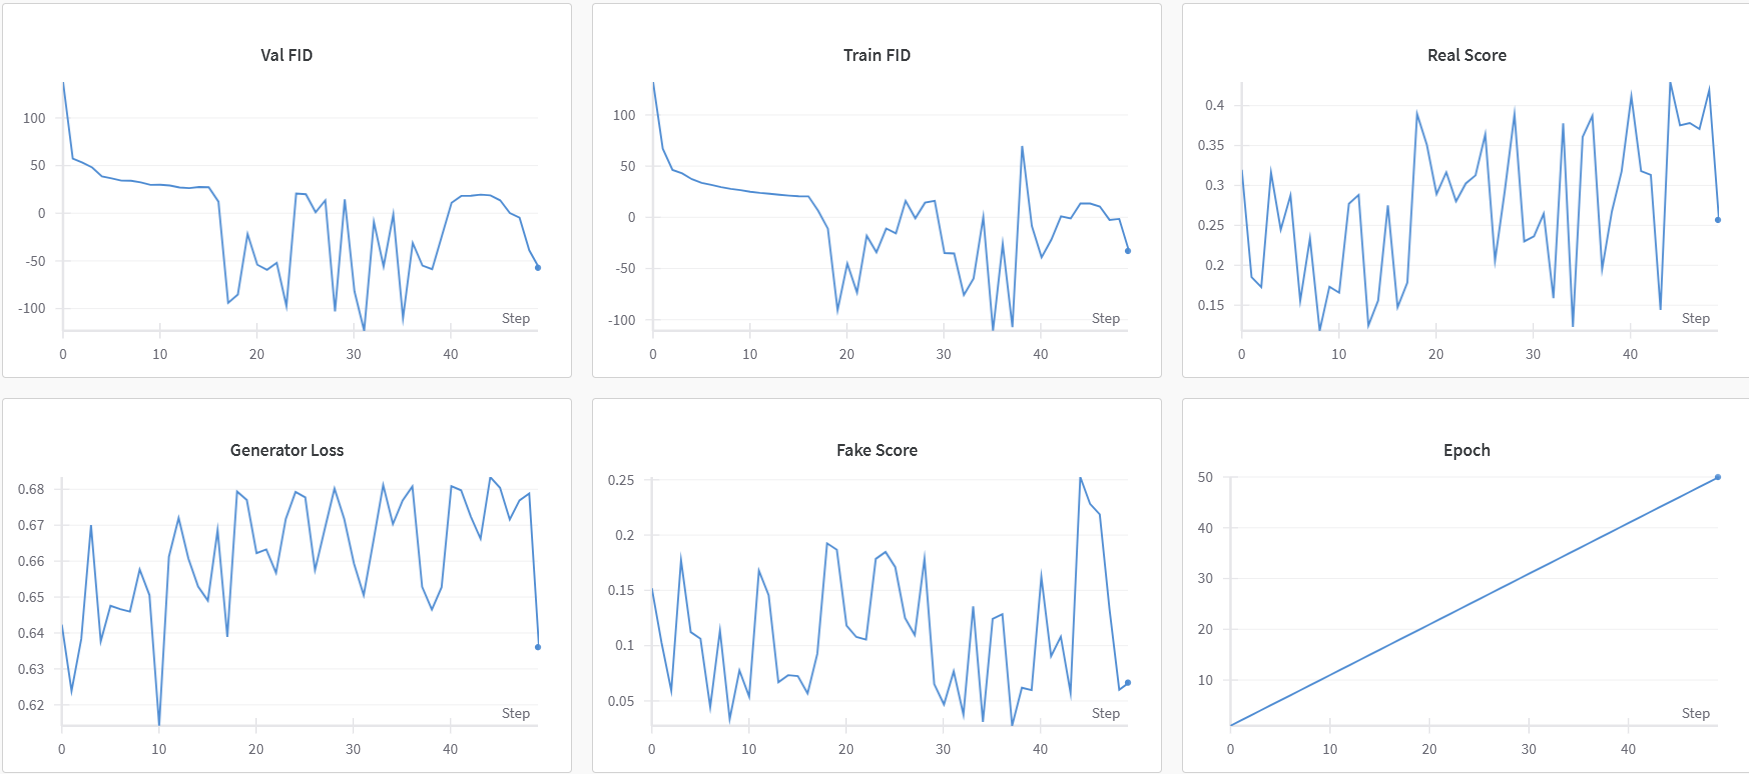

- Fake Score 0.05~ 0.2 사이를 왔다가 갔다가 함
- Real Score : 0.15 ~ 0.4 사이
- G Loss : 전체 적으로 큰 변동 없이 0.64 대를 유지하다가 조금씩 상승하는 모습을 보임
- D Loss : 큰 변동폭 없이 1.3대를 유지
- FID 점진적으로 FID score가 감소하는 모습을 보이더니 음수값까지 내려감

- 비록 D Loss와 G Loss는 눈에 띄는 큰 변동폭이 없었으나 , Real/Fake Score의 변화와 FID 감소는
모델이 점진적으로 학습을 했음을 보여줌
- 10에폭 마다 출력되는 이미지로 시각적 분석을 해봤을때 Bag의 손잡이 부분이라던가 / Ankle boot의 신발끈이라던가 굽이라던가 밑창이라던가 에폭이 늘수록 더 디테일한 부분까지 묘사하며 모델이 이미지 생성을 하고 있음을 확인할 수있습니다.
- 이전 MLP 형식의 모델보다 훨씬 더 부드러운 경계선과 곡선을 표현 할수 있고 / 훨씬더 좋은 학습 속도를 보여 주었습디다.
- 다만 FID score가 음수값까지 내려가는 현상이 발생했는데 이는 FID score를 계산하는 과정에서 이미지 값의 범위를 잘못 설정했거나 계산방식에서 문제가 발생함을 시사함으로 계산 방식/데이터 정제 확인이 필요합니다

## 느낀점 및 소감

- MLP 구조와 CNN 구조의 모델 비교를 통해 CNN이 훨씬더 이미지 학습이나 생성 부분에서 뛰어난 성능을 나타냄을 한번 더 확인할 수 있었습니다
- 특히나 공간적 정보를 활용하는 모델과 활용하지 않는 모델의 차이점을 생성 이미지를 통해 확실히 비교해볼 수 있었습니다.
- cGAN 모델은 Discriminator 모델의 성능이 너무 뛰어날 경우 g_loss의 값이 너무 작아져서 g모델의 학습이 굉장히 늦어질수 있기 때문에 다양한 방법을 통해 Fake Sore가 어느정도 잘 상승할수 있도록 모델을 설계하는 것이 중요하다고 느꼈습니다.
- cGAN 모델의 경우 d_loss 나 g_loss 뿐만 아니라 real_score와 fake_score까지 확인을 하는것이 모델의 학습 상황을 정확하게 파악하는데 도움이 되며 특히 fid 지표는 생성 이미지의 퀄리티가 얼마나 원본과 유사한지 잘 확인할 수 있는 지표였습니다.
- MLP 모델보다 CNN 모델에서의 Fake Score 구간이 0.05~0.2 사이로 줄어들었는데 Label smoothing 기법을 사용해서 real_labes 의 수치에 0.9정도의 수를 곱해서 real 이미지를 100% 진짜라고 확신하지 않도록 하는 방법을 통해서 Fake Score의 구간이 조금더 넓어지게 하는 실험도 해볼만 하다고 생각이 들었습니다.
- label condition을 one-hot vector로 넣던 방식에서 embedding을 거쳐서 넣는식으로 변경해서
(현재는 one-hot + concat 방식 / 라벨을 임베딩 해서 noise와 곱하거나 projection해서 입력에 더하는 방식으로 변경(infoGAN과 같은 구조)) 실험해 보지 못한점이 아쉬움이 남습니다.
- FID 계산을 정상화 하지 못한 부분이 보완해야할 부분입니다

### 멘토의견

전반적으로 매우 탄탄한 실험 설계와 구현이 돋보였습니다. MLP 기반 cGAN에서 CNN 기반 cGAN으로 확장하며 공간 정보를 효과적으로 활용한 구조 개선과, Fake Score·Real Score·G Loss·FID 등 다양한 지표를 함께 분석해 학습 과정을 입체적으로 파악한 점이 인상적입니다. 또한, 코드 전반에 걸쳐 주석과 설명을 충실히 달아 가독성과 이해도가 높아졌습니다. 몇 가지 구현상의 버그(데이터로더, FID 계산)만 수정하면 더 좋은 프로젝트가 될 것 같습니다. 수고하셨습니다 :)